# 3. Supervised Learning

### 3.1. Import Modules

Import relevant modules in one place.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

import seaborn as sns
sns.set(rc={'figure.figsize':(16,8)}) # set the figure size for all sns plots
#sns.set_palette('flare')
sns.set_style('whitegrid')

# to hide errors
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')


from statsmodels.tsa.arima.model import ARIMA
import itertools

from statsmodels.tsa.api import SARIMAX
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import ExponentialSmoothing

from sklearn.model_selection import TimeSeriesSplit

import statistics

### 3.2 Read Data

#### Bitcoin

In [2]:
path = 'data/bitcoin.csv'
df = pd.read_csv(path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4216 entries, 0 to 4215
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    4216 non-null   object 
 1   close   4216 non-null   float64
dtypes: float64(1), object(1)
memory usage: 66.0+ KB


In [3]:
# Column names: remove white spaces, convert to lower case, add _ instead of space
df.columns = df.columns.str.strip().str.lower().str.replace(' ','_')
df.head()

,date,close
0,2009/10/05,0.000764
1,2009/10/06,0.000885
2,2009/10/07,0.001050
3,2009/10/08,0.001084
4,2009/10/09,0.001200


In [4]:
df['date'] = pd.to_datetime(df['date']) # convert date to datetime
df.dtypes

date     datetime64[ns]
close           float64
dtype: object

In [5]:
df = df.set_index('date') # set index

In [6]:
df = df.loc['2009-11-01':'2021-03-31'] # subset to have complete data on all months
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4169 entries, 2009-11-01 to 2021-03-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   4169 non-null   float64
dtypes: float64(1)
memory usage: 65.1 KB


In [7]:
daily_series = df['close'].copy()
daily_series.head()

date
2009-11-01    0.001219
2009-11-02    0.001256
2009-11-03    0.001273
2009-11-04    0.001306
2009-11-05    0.001306
Name: close, dtype: float64

#### Weekly Data

In [8]:
weekly_series = df['close'].copy().resample('W').last()
weekly_series.head()

date
2009-11-01    0.001219
2009-11-08    0.001260
2009-11-15    0.001236
2009-11-22    0.001059
2009-11-29    0.000829
Freq: W-SUN, Name: close, dtype: float64

In [9]:
weekly_train = weekly_series.loc[ weekly_series.index < '2020-03-31' ].copy()
weekly_train.tail()

date
2020-03-01    8540.2567
2020-03-08    8050.1883
2020-03-15    5360.0600
2020-03-22    5803.6700
2020-03-29    5882.0067
Freq: W-SUN, Name: close, dtype: float64

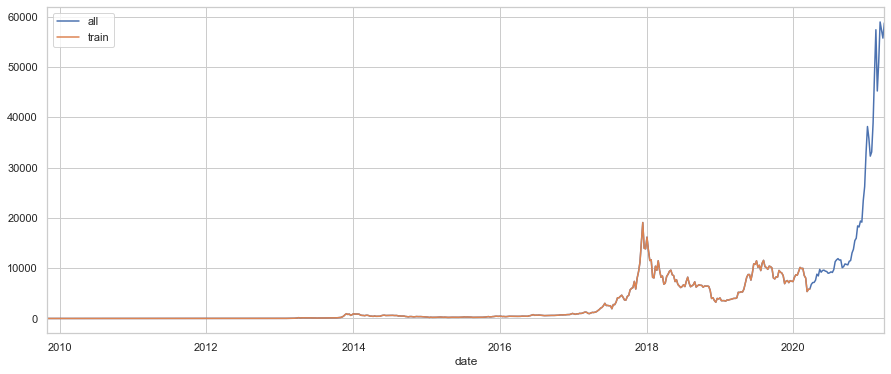

In [10]:
fig, ax = plt.subplots(figsize=(15, 6))
weekly_series.plot(ax=ax, label='all')
weekly_train.plot(ax=ax, label='train') 
ax.legend()
plt.show()

##### Monthly Data - LOG transformed for the future analysis

In [11]:
# log transform
df['close'] = np.log(df['close'])

In [12]:
monthly_series = df['close'].copy().resample('MS').last()
monthly_series = monthly_series.loc[ monthly_series.index < '2019-11-01'].copy()
monthly_series.tail()

date
2019-06-01    9.284466
2019-07-01    9.219353
2019-08-01    9.170419
2019-09-01    9.026042
2019-10-01    9.123078
Freq: MS, Name: close, dtype: float64

In [13]:
monthly_train = monthly_series.loc[ monthly_series.index < '2018-06-01' ].copy()
monthly_train.tail()

date
2018-01-01    9.226854
2018-02-01    9.240835
2018-03-01    8.843040
2018-04-01    9.131765
2018-05-01    8.920949
Freq: MS, Name: close, dtype: float64

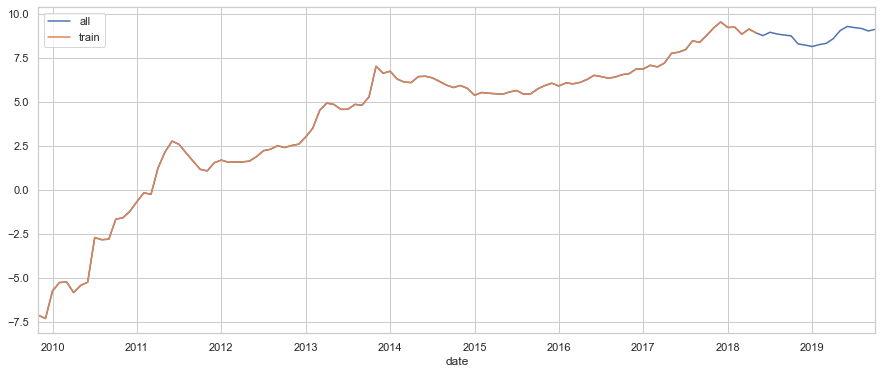

In [14]:
fig, ax = plt.subplots(figsize=(15, 6))
monthly_series.plot(ax=ax, label='all')
monthly_train.plot(ax=ax, label='train') 
ax.legend()
plt.show()

#### Exogenous

In [15]:
path = 'data/exogenous.csv'
df_exo = pd.read_csv(path)
df_exo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2846 entries, 0 to 2845
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    2846 non-null   object 
 1   gold    2846 non-null   float64
 2   oil     2846 non-null   float64
 3   spx     2846 non-null   float64
 4   vfh     2846 non-null   float64
 5   vgt     2846 non-null   float64
 6   nvda    2846 non-null   float64
dtypes: float64(6), object(1)
memory usage: 155.8+ KB


In [16]:
df_exo['date'] = pd.to_datetime(df_exo['date']) # convert date to datetime
df_exo.dtypes

date    datetime64[ns]
gold           float64
oil            float64
spx            float64
vfh            float64
vgt            float64
nvda           float64
dtype: object

In [17]:
df_exo = df_exo.set_index('date') # set index

#### Merge the datasets

In [18]:
df_full = df_exo.merge(df['close'], left_index=True, right_index=True, how='left')
df_full.rename(columns = {'close' : 'bitcoin'}, inplace = True)
df_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2846 entries, 2009-11-02 to 2021-03-31
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gold     2846 non-null   float64
 1   oil      2846 non-null   float64
 2   spx      2846 non-null   float64
 3   vfh      2846 non-null   float64
 4   vgt      2846 non-null   float64
 5   nvda     2846 non-null   float64
 6   bitcoin  2846 non-null   float64
dtypes: float64(7)
memory usage: 257.9 KB


In [19]:
df_full

,gold,oil,spx,vfh,vgt,nvda,bitcoin
date,,,,,,,
2009-11-02,1053.400024,78.129997,1042.88,28.270000,49.459999,12.070000,-6.679823
2009-11-03,1084.300049,79.599998,1045.41,28.379999,49.450001,12.010000,-6.666379
2009-11-04,1086.699951,80.400002,1046.50,28.030001,49.770000,11.980000,-6.640786
2009-11-05,1088.699951,79.620003,1066.63,28.660000,50.930000,12.270000,-6.640786
2009-11-06,1095.099976,77.430000,1069.30,28.559999,51.020000,13.160000,-6.656219
...,...,...,...,...,...,...,...
2021-03-25,1724.900024,58.560001,3909.52,84.370003,349.890015,501.410004,10.846309
2021-03-26,1732.199951,60.970001,3974.54,85.410004,357.589996,513.570007,10.915925
2021-03-29,1712.099976,61.560001,3971.09,84.430000,354.899994,517.929993,10.961999


### 3.3 Train Models 
Using **monthly** data.

In [20]:
def make_forecast(my_mod, start_time, final_time):
    forecast_object = my_mod.get_prediction(start_time, final_time)
    forecast_mean = forecast_object.predicted_mean
    forecast_ci = forecast_object.conf_int()
    
    res = pd.DataFrame({'forecast_mean': forecast_mean,
                        'forecast_lwr': forecast_ci.iloc[:, 0],
                        'forecast_upr': forecast_ci.iloc[:, 1]},
                      index=forecast_ci.index)
    
    return res

## (1) ARIMA

_Tuning:_

In [21]:
# define arguments
p_grid = list(range(1, 7, 1))
d_grid = range(0, 4)
q_grid = range(0, 4)

pdq = list( itertools.product(p_grid, d_grid, q_grid) )

In [22]:
pdq_results = []
aic_results = []

# MONTHLY DATA
for param in pdq:
    try:
        mod_fit = ARIMA( monthly_train, 
                         order=param, 
                         enforce_stationarity=True, # more recent data matters most
                         enforce_invertibility=True).fit(method_kwargs={'maxiter':50001})
        pdq_results.append(param)
        aic_results.append(mod_fit.aic)
        
        print('ARIMA{} - AIC:{}'.format(param, mod_fit.aic))
    except:
        continue

ARIMA(1, 0, 0) - AIC:155.5475141491796
ARIMA(1, 0, 1) - AIC:154.03291354998538
ARIMA(1, 0, 2) - AIC:154.22602068655152
ARIMA(1, 0, 3) - AIC:156.00331280293815
ARIMA(1, 1, 0) - AIC:142.45636396714735
ARIMA(1, 1, 1) - AIC:138.61272285068026
ARIMA(1, 1, 2) - AIC:140.26430627351877
ARIMA(1, 1, 3) - AIC:142.17060317241913
ARIMA(1, 2, 0) - AIC:167.89295022805962
ARIMA(1, 2, 1) - AIC:138.64003440058036
ARIMA(1, 2, 2) - AIC:140.63820687810878
ARIMA(1, 2, 3) - AIC:141.7280146858228
ARIMA(1, 3, 0) - AIC:239.93266280124536
ARIMA(1, 3, 1) - AIC:174.65732922707784


C:\Users\Anastasia\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 3, 2) - AIC:148.04477379236852
ARIMA(1, 3, 3) - AIC:150.6002507379305
ARIMA(2, 0, 0) - AIC:153.19057727526138
ARIMA(2, 0, 1) - AIC:148.62436267178705
ARIMA(2, 0, 2) - AIC:156.23370081183154


C:\Users\Anastasia\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(2, 0, 3) - AIC:158.00834643330037
ARIMA(2, 1, 0) - AIC:143.2440854487177
ARIMA(2, 1, 1) - AIC:140.24916693070202
ARIMA(2, 1, 2) - AIC:142.51225339744693
ARIMA(2, 1, 3) - AIC:143.32494297949938
ARIMA(2, 2, 0) - AIC:163.53725193734755
ARIMA(2, 2, 1) - AIC:140.63139599667252
ARIMA(2, 2, 2) - AIC:141.89521011941514
ARIMA(2, 2, 3) - AIC:137.17739864488004
ARIMA(2, 3, 0) - AIC:220.7927655140079
ARIMA(2, 3, 1) - AIC:170.77908168563937
ARIMA(2, 3, 2) - AIC:151.01446541066878
ARIMA(2, 3, 3) - AIC:151.09866076094502
ARIMA(3, 0, 0) - AIC:153.94525887142314
ARIMA(3, 0, 1) - AIC:155.67009640468348
ARIMA(3, 0, 2) - AIC:151.9617336668845
ARIMA(3, 0, 3) - AIC:158.99407393855375
ARIMA(3, 1, 0) - AIC:145.24251254274432
ARIMA(3, 1, 1) - AIC:147.24405451124215
ARIMA(3, 1, 2) - AIC:143.49594097309893
ARIMA(3, 1, 3) - AIC:143.18488576020394
ARIMA(3, 2, 0) - AIC:160.2356931407761
ARIMA(3, 2, 1) - AIC:141.5954073987397
ARIMA(3, 2, 2) - AIC:143.45332502513665
ARIMA(3, 2, 3) - AIC:139.07251766251892
ARIMA

_Finding the optimal or tuned number of lags for this application:_

In [23]:
arima_results_df = pd.DataFrame({'p': [pdq_results[n][0] for n in range(len(pdq_results))],
                                 'd': [pdq_results[n][1] for n in range(len(pdq_results))],
                                 'q': [pdq_results[n][2] for n in range(len(pdq_results))],
                                 'AIC': aic_results})

In [24]:
arima_results_df.sort_values(['AIC'], ascending=True)

,p,d,q,AIC
27,2,2,3,137.177399
75,5,2,3,138.030137
5,1,1,1,138.612723
9,1,2,1,138.640034
43,3,2,3,139.072518
...,...,...,...,...
76,5,3,0,190.081281
60,4,3,0,207.946664
44,3,3,0,208.482605
28,2,3,0,220.792766


In [25]:
best_pdq_df = arima_results_df.loc[ arima_results_df.AIC == arima_results_df.AIC.min(), :].copy()
best_pdq_df

,p,d,q,AIC
27,2,2,3,137.177399


_Train the best model:_

In [26]:
best_pdq_tuple = (best_pdq_df.p.to_list()[0], best_pdq_df.d.to_list()[0], best_pdq_df.q.to_list()[0])
best_pdq_tuple

(2, 2, 3)

In [27]:
monthly_tune_fit = ARIMA(monthly_train, 
                      order=best_pdq_tuple, 
                      enforce_stationarity=False,
                      enforce_invertibility=False).fit(method_kwargs={'maxiter':10001})
monthly_tune_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                  103
Model:                 ARIMA(2, 2, 3)   Log Likelihood                 -49.927
Date:                Tue, 27 Apr 2021   AIC                            111.855
Time:                        22:49:44   BIC                            127.303
Sample:                    11-01-2009   HQIC                           118.101
                         - 05-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0682      0.048    -22.059      0.000      -1.163      -0.973
ar.L2         -0.8518      0.037    -22.985      0.000      -0.924      -0.779
ma.L1          0.2258    713.914      0.000      1.000   -1399.020    1399.471
ma.L2         -0.0416    600.273  -6.94e-05      1.000   -1176.555    1176.472
ma.L3         -0.9139   1144.974     -0.001      0.999   -2245.022    2243.194
sigma2         0.1530    191.645      0.001      0.999    -375.464     375.770
===================================================================================
Ljung-Box (L1) (Q):                   1.15   Jarque-Bera (JB):               107.57
Prob(Q):                              0.28   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                             1.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

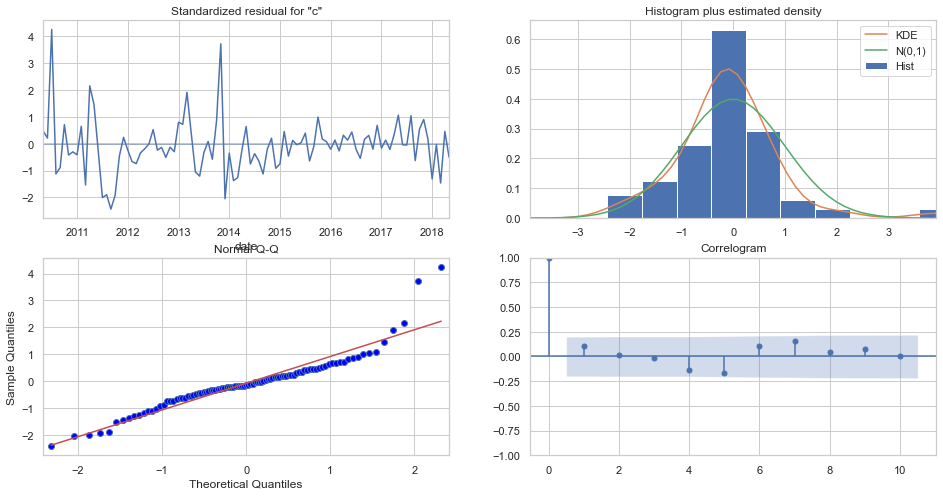

In [28]:
monthly_tune_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

In [29]:
monthly_tune_forecast = monthly_tune_fit.forecast(6) # 6 months ahead

In [30]:
h_start = monthly_tune_forecast.index.min()
h_final = monthly_tune_forecast.index.max()

In [31]:
monthly_tune_forecast_summary = make_forecast( monthly_tune_fit, h_start, h_final )

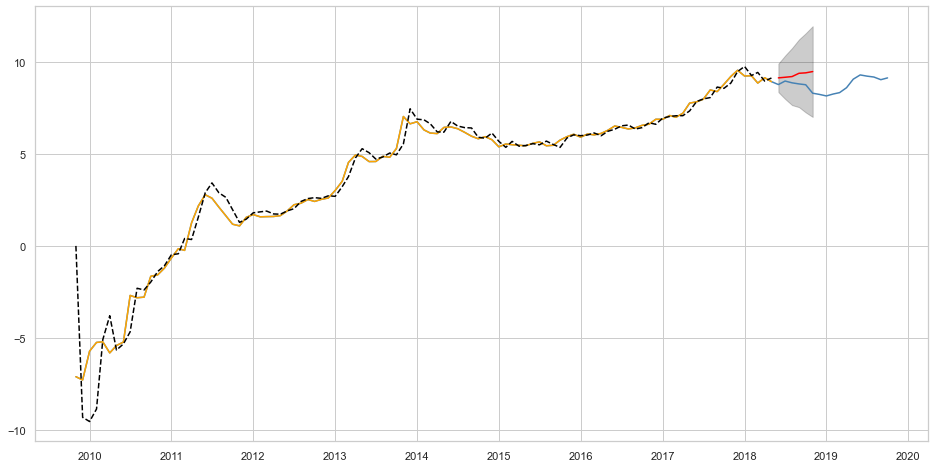

In [32]:
plt.figure(figsize=(16, 8))
plt.plot( monthly_series, color='steelblue' ) # observed test
plt.plot( monthly_train, color='orange' ) # observed train
plt.plot( monthly_tune_fit.fittedvalues, color='black', linestyle='--') # fitted
plt.plot( monthly_tune_forecast, color='red' ) # forecasted
plt.fill_between( 
    monthly_tune_forecast_summary.index, 
    monthly_tune_forecast_summary.forecast_lwr, 
    monthly_tune_forecast_summary.forecast_upr, 
    color = 'black',
    alpha=0.2)

plt.show()

In [33]:
# fucniton to back transform
def undo_log_transform(z, a):
    return( np.exp(z) - a )

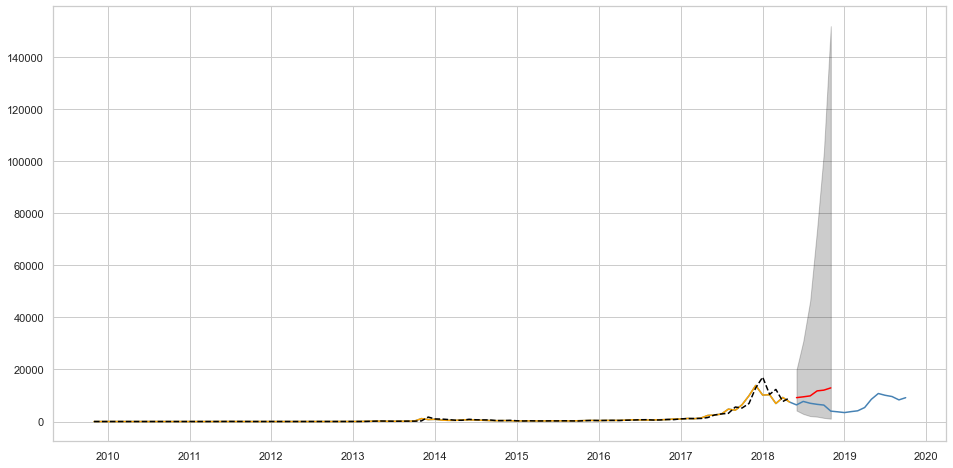

In [34]:
#forecasting median (NOT mean) behavior
plt.figure(figsize=(16, 8))
plt.plot( monthly_series.index, 
         undo_log_transform(monthly_series.values, 0), color='steelblue' ) # observed test
plt.plot( monthly_train.index,
         undo_log_transform(monthly_train.values, 0), color='orange' ) # observed train
plt.plot( monthly_train.index,
         undo_log_transform(monthly_tune_fit.fittedvalues, 0), color='black', linestyle='--') # fitted
plt.plot( monthly_tune_forecast.index,
         undo_log_transform(monthly_tune_forecast.values, 0), color='red' ) # forecasted
plt.fill_between( 
    monthly_tune_forecast_summary.index, 
    undo_log_transform(monthly_tune_forecast_summary.forecast_lwr, 0), 
    undo_log_transform(monthly_tune_forecast_summary.forecast_upr, 0),
color = 'black',
alpha=0.2)
plt.show()

_Note the large confidence interval because of the log-transformation._

## (2) SES with STL 

In [35]:
monthly_ses_fit = STLForecast( monthly_train, SimpleExpSmoothing, 
                            model_kwargs={'initialization_method':'estimated'}).fit()
monthly_ses_fit.summary()

Dep. Variable:,None,No. Observations:,103
Model:,SimpleExpSmoothing,SSE,16.353
Optimized:,True,AIC,-185.555
Trend:,None,BIC,-180.285
Seasonal:,None,AICC,-185.147
Seasonal Periods:,None,Date:,"Tue, 27 Apr 2021"
Box-Cox:,False,Time:,22:49:46
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
initial_level,-6.8970577,l.0,True


In [36]:
monthly_ses_forecast = monthly_ses_fit.forecast(6) # 6 months ahead

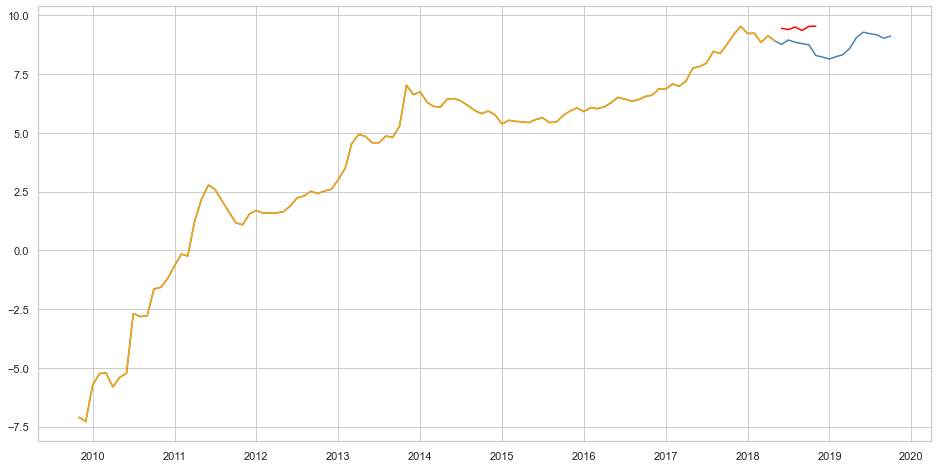

In [37]:
plt.figure(figsize=(16, 8))
plt.plot( monthly_series, color='steelblue' ) # observed test
plt.plot( monthly_train, color='orange' ) # observed train
plt.plot( monthly_ses_forecast, color='red') # forecasted
plt.show()

## (3) Holt-Winters method

In [38]:
monthly_hw_fit = ExponentialSmoothing(monthly_train, 
                                      seasonal_periods=12, # how many periods in a year
                                      trend='add', 
                                      seasonal='add',
                                      use_boxcox=False,
                                      initialization_method='estimated').fit()
monthly_hw_fit.summary()

Dep. Variable:,close,No. Observations:,103
Model:,ExponentialSmoothing,SSE,19.979
Optimized:,True,AIC,-136.923
Trend:,Additive,BIC,-94.767
Seasonal:,Additive,AICC,-128.780
Seasonal Periods:,12,Date:,"Tue, 27 Apr 2021"
Box-Cox:,False,Time:,22:49:46
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_trend,0.0564892,beta,True


In [39]:
monthly_hw_forecast = monthly_hw_fit.forecast(6)

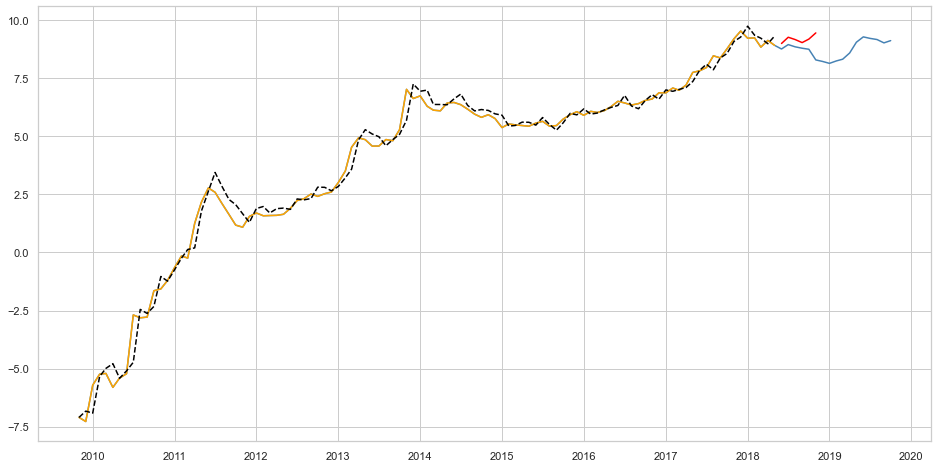

In [40]:
plt.figure(figsize=(16, 8))
plt.plot( monthly_series, color='steelblue' ) # observed test
plt.plot( monthly_train, color='orange' ) # observed train
plt.plot( monthly_hw_fit.fittedvalues, color='black', linestyle='--') # fitted
plt.plot( monthly_hw_forecast, color='red') # forecasted
plt.show()

_Disregard... tried to find RMSE via CV._

In [41]:
# RMSE_hw = (np.mean( (monthly_val.values - monthly_hw_forecast)**2 )**0.5)
# RMSE_hw

# input_df = pd.DataFrame(monthly_train) # input data

# rmse_results = []
# rmse_results_mean = []

# for i in range(1,20):
#     try:
#         rmse_within = [] # to record rmses within a fold
#         tscv = TimeSeriesSplit(n_splits=3) # define tscv
        
#         for train_id, test_id in tscv.split(input_df.to_numpy()):
            
#             train_df = input_df.iloc[train_id, :].copy()
#             test_df = input_df.iloc[test_id, :].copy()
            
#             mod_fit =  ExponentialSmoothing(
#                 train_df, # fit on train data
#                 seasonal_periods=12, # how many periods in a year
#                 trend='add', 
#                 seasonal='add',
#                 use_boxcox=False,
#                 initialization_method='estimated').fit()
            
#             mod_forecast = mod_fit.forecast(len(test_df)) # forecast on the trainig set
#             rmse = (np.mean( (test_df.values - mod_forecast.values)**2 )**0.5) # calculate rmse (test - forecast)
            
#             rmse_within.append(rmse) # add current rmse to the list

#         rmse_results.append(rmse_within)
#         rmse_results_mean.append(statistics.mean(rmse_within))
        
#         print('HW - RMSE: mean: {} \n all: {}'.format(statistics.mean(rmse_within), rmse_within))
#     except:
#         continue

## (4) Time Series CV

In [42]:
tscv05 = TimeSeriesSplit(n_splits=5)

In [43]:
# function which extracts the training and test splits within each fold.
def extract_ts_folds(df, cv):
    res_list = []
    
    # combine the training and test splits in each fold
    for train_id, test_id in cv.split(df.to_numpy()):
        train_df = df.iloc[train_id, :].copy()
        train_df['split_name'] = 'training'
        
        test_df = df.iloc[test_id, :].copy()
        test_df['split_name'] = 'testing'
        
        res_list.append( pd.concat([train_df, test_df]) )
    
    # assign the fold id
    for i, res in enumerate( res_list ):
        res['fold_id'] = i
    
    # combine all folds together
    res_df = pd.concat( res_list )
    
    return res_df

In [44]:
monthly_ts_folds = extract_ts_folds( pd.DataFrame(monthly_train), tscv05 )

In [45]:
monthly_ts_folds.head()

,close,split_name,fold_id
date,,,
2009-11-01,-7.101340,training,0
2009-12-01,-7.280269,training,0
2010-01-01,-5.714439,training,0
2010-02-01,-5.240426,training,0
2010-03-01,-5.208111,training,0


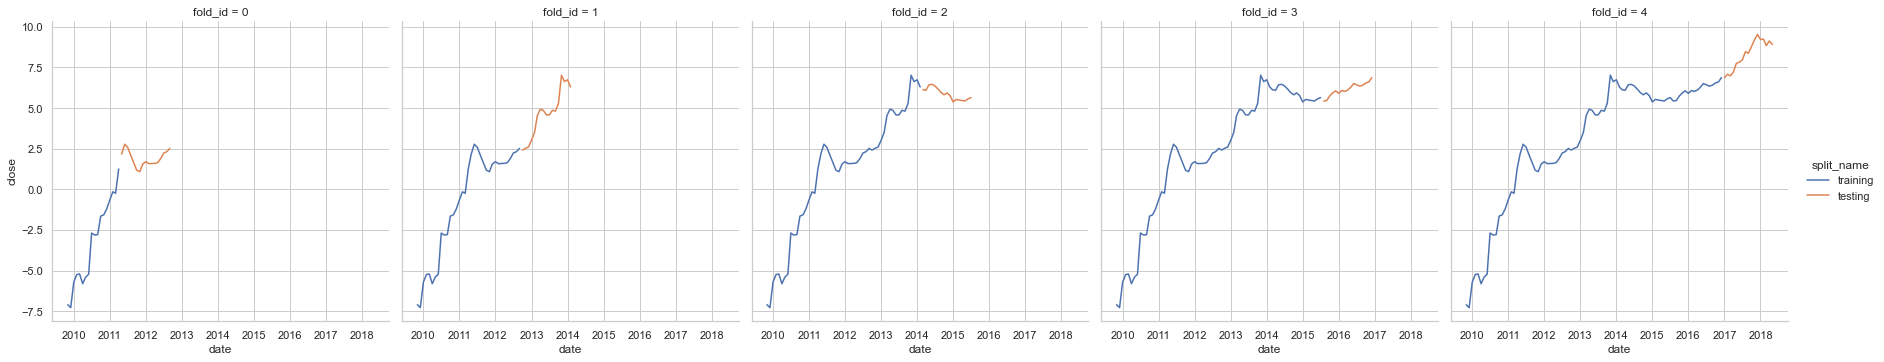

In [46]:
# Visualize time series splits
sns.relplot( data = monthly_ts_folds.reset_index(), 
            x='date', y='close', hue='split_name', kind='line', col='fold_id' )
plt.show()

### ARIMA with CV

In [47]:
tscv = TimeSeriesSplit(n_splits=5)

In [48]:
# defining arguments
p_grid = list(range(1, 7, 1))
d_grid = range(0, 4)
q_grid = range(0, 4)

pdq = list( itertools.product(p_grid, d_grid, q_grid) )

In [49]:
input_df = pd.DataFrame(monthly_train)

pdq_results = []
aic_results = []
aic_results_mean = []

for param in pdq:
    try:
        
        aic_within = []
        for train_id, test_id in tscv.split(input_df.to_numpy()):

            train_df = input_df.iloc[train_id, :].copy()
            test_df = input_df.iloc[test_id, :].copy()

            mod_fit = ARIMA( train_df, 
                             order=param, 
                             enforce_stationarity=True, # more recent data matters most
                             enforce_invertibility=True).fit(method_kwargs={'maxiter':50001})
            aic_within.append(mod_fit.aic)
            
        pdq_results.append(param)
        aic_results.append(aic_within)
        aic_results_mean.append(statistics.mean(aic_within))
        
        print('ARIMA{} - AIC: mean: {} \n all: {}'.format(param, statistics.mean(aic_within), aic_within))
    except:
        continue

ARIMA(1, 0, 0) - AIC: mean: 104.76503687946729 
 all: [56.1706219917485, 83.22927862910059, 113.68039781036319, 129.31169830032178, 141.4331876658024]


C:\Users\Anastasia\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Anastasia\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1) - AIC: mean: 104.91916530698887 
 all: [58.08114030725921, 83.89287988541386, 113.72521654664521, 128.699026949058, 140.19756284656805]
ARIMA(1, 0, 2) - AIC: mean: 106.09789372252652 
 all: [59.82467941054012, 85.30431506183247, 114.79360664481591, 129.62606824180924, 140.94079925363488]
ARIMA(1, 0, 3) - AIC: mean: 107.9634951673962 
 all: [61.73153707886075, 87.16614573174043, 116.6497326965024, 131.47716489483304, 142.7928954350444]
ARIMA(1, 1, 0) - AIC: mean: 94.55610081972686 
 all: [48.76715980650799, 74.0300650547564, 102.98503630018249, 117.91783201768733, 129.08041091950008]


C:\Users\Anastasia\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 1, 1) - AIC: mean: 93.26093559725054 
 all: [47.83609881733759, 73.81154956656538, 101.5105639838348, 116.52181121927553, 126.62465439923936]
ARIMA(1, 1, 2) - AIC: mean: 94.61566027237653 
 all: [47.53790471402109, 75.78239892877619, 103.30322607135538, 118.2253330593157, 128.22943858841427]
ARIMA(1, 1, 3) - AIC: mean: 96.36538821718317 
 all: [48.34561778967918, 77.7800065906455, 105.28443298452562, 120.20476400756168, 130.21211971350385]
ARIMA(1, 2, 0) - AIC: mean: 106.44714975764788 
 all: [50.59169543960384, 81.15186242652764, 114.7966794042103, 134.86374401279903, 150.83176750509855]
ARIMA(1, 2, 1) - AIC: mean: 92.61677828641736 
 all: [45.393893386430236, 73.48938951921677, 101.14153106763486, 116.48827959972381, 126.57079785908114]
ARIMA(1, 2, 2) - AIC: mean: 94.12606311482507 
 all: [44.92962265558202, 75.50241033469639, 103.1413880283799, 118.48785351049844, 128.56904104496863]
ARIMA(1, 2, 3) - AIC: mean: 96.00563306403625 
 all: [47.7388301074257, 77.35307535628401, 

ARIMA(4, 3, 0) - AIC: mean: 128.5613606131689 
 all: [60.18555191704499, 97.62544010604795, 136.37372914169345, 163.4912624467749, 185.13081945428317]
ARIMA(4, 3, 1) - AIC: mean: 111.09982606406999 
 all: [57.538167759626845, 87.91815415049, 120.06204235260849, 138.2178568032067, 151.7629092544179]
ARIMA(4, 3, 2) - AIC: mean: 114.51511285434862 
 all: [59.95716415149951, 90.2868345887625, 123.55426107694028, 142.30920335435977, 156.46810110018103]


C:\Users\Anastasia\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 3, 3) - AIC: mean: 105.58291846306041 
 all: [16.0, 89.6191690630246, 122.77448024806593, 143.84159837393128, 155.67934463028027]
ARIMA(5, 0, 0) - AIC: mean: 109.64928532967629 
 all: [62.81440434775901, 88.8309447713741, 118.55029692880407, 133.3993310715239, 144.65144952892032]
ARIMA(5, 0, 1) - AIC: mean: 110.4889698200586 
 all: [59.980546367957025, 90.72227224011577, 120.34998997269872, 135.11066540740808, 146.28137511211344]
ARIMA(5, 0, 2) - AIC: mean: 109.23092612565289 
 all: [64.5186624960348, 88.95649083854737, 118.38462130870062, 132.32638559109023, 141.9684703938914]
ARIMA(5, 0, 3) - AIC: mean: 111.19861450320913 
 all: [66.27332370322429, 90.90952813348588, 119.88350262643918, 135.7259087148107, 143.20080933808555]
ARIMA(5, 1, 0) - AIC: mean: 101.4296170126037 
 all: [54.94856124031852, 81.13723230376954, 110.13098583109354, 124.99500747540628, 135.9362982124306]
ARIMA(5, 1, 1) - AIC: mean: 99.32489569482364 
 all: [52.91567572012552, 81.08662228750683, 108.1669093

C:\Users\Anastasia\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(5, 3, 3) - AIC: mean: 99.91951266745734 
 all: [18.0, 88.75905312212274, 122.21242139736428, 130.42833042983557, 140.1977583879641]
ARIMA(6, 0, 0) - AIC: mean: 111.26518079440288 
 all: [64.1863559346891, 90.45706504122285, 120.28311240232814, 135.10548017132322, 146.29389042245106]
ARIMA(6, 0, 1) - AIC: mean: 112.11249631289071 
 all: [60.33146613959906, 92.72199691981108, 122.3047692637049, 137.0171056350776, 148.18714360626095]
ARIMA(6, 0, 2) - AIC: mean: 110.21694958667614 
 all: [63.473448009280766, 90.89672506061957, 119.93053519616028, 133.67161150906412, 143.11242815825597]
ARIMA(6, 0, 3) - AIC: mean: 112.71422372995657 
 all: [68.23804291279711, 92.89562075533442, 121.7767310448976, 135.6198727927287, 145.040851144025]
ARIMA(6, 1, 0) - AIC: mean: 97.29719698617856 
 all: [52.240050125768896, 78.87218477401339, 106.80904746301255, 119.65439015381217, 128.91031241428584]
ARIMA(6, 1, 1) - AIC: mean: 98.55085994343335 
 all: [53.44221564435318, 80.85391726792389, 107.9306334

_Finding the optimal or tuned number of lags for this application:_

In [50]:
arima_cv_results_df = pd.DataFrame({'p': [pdq_results[n][0] for n in range(len(pdq_results))],
                                 'd': [pdq_results[n][1] for n in range(len(pdq_results))],
                                 'q': [pdq_results[n][2] for n in range(len(pdq_results))],
                                 'AIC': aic_results_mean})

In [51]:
arima_cv_results_df.sort_values(['AIC'], ascending=True)

,p,d,q,AIC
9,1,2,1,92.616778
5,1,1,1,93.260936
10,1,2,2,94.126063
25,2,2,1,94.512122
4,1,1,0,94.556101
...,...,...,...,...
44,3,3,0,127.749474
60,4,3,0,128.561361
28,2,3,0,132.437072
12,1,3,0,141.053169


In [52]:
cv_best_pdq_df = arima_cv_results_df.loc[ arima_cv_results_df.AIC == arima_cv_results_df.AIC.min(), :].copy()
cv_best_pdq_df

,p,d,q,AIC
9,1,2,1,92.616778


_Train the best model:_

In [53]:
cv_best_pdq_tuple = (cv_best_pdq_df.p.to_list()[0], cv_best_pdq_df.d.to_list()[0], cv_best_pdq_df.q.to_list()[0])
cv_best_pdq_tuple

(1, 2, 1)

In [54]:
monthly_cv_tune_fit = ARIMA(input_df, 
                      order=cv_best_pdq_tuple, 
                      enforce_stationarity=False,
                      enforce_invertibility=False).fit(method_kwargs={'maxiter':10001})
monthly_cv_tune_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                  103
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 -63.183
Date:                Tue, 27 Apr 2021   AIC                            132.365
Time:                        22:51:58   BIC                            140.151
Sample:                    11-01-2009   HQIC                           135.515
                         - 05-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0967      0.074      1.298      0.194      -0.049       0.243
ma.L1         -0.9372      0.082    -11.392      0.000      -1.098      -0.776
sigma2         0.2067      0.022      9.420      0.000       0.164       0.250
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               163.58
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.13   Skew:                             1.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

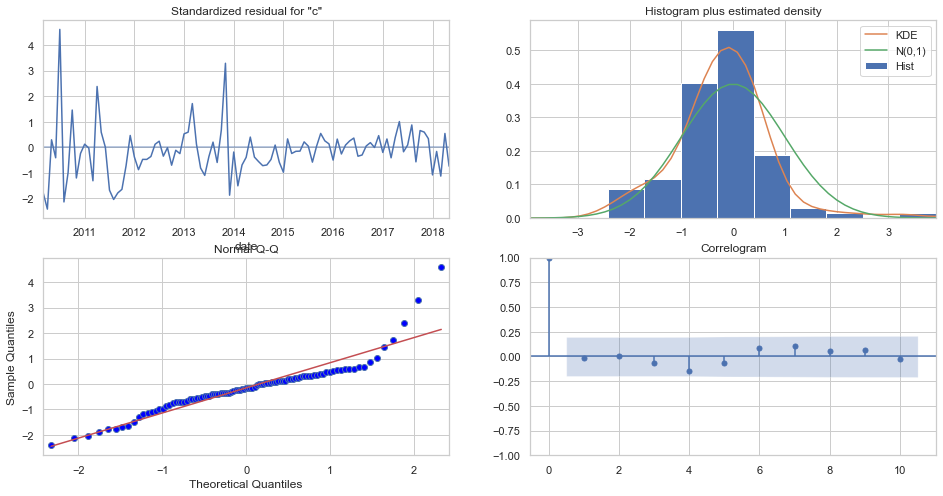

In [55]:
monthly_cv_tune_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

In [56]:
monthly_cv_tune_forecast = monthly_cv_tune_fit.forecast(6) 

In [57]:
h_start = monthly_cv_tune_forecast.index.min()
h_final = monthly_cv_tune_forecast.index.max()

In [58]:
monthly_cv_tune_forecast_summary = make_forecast( monthly_cv_tune_fit, h_start, h_final )

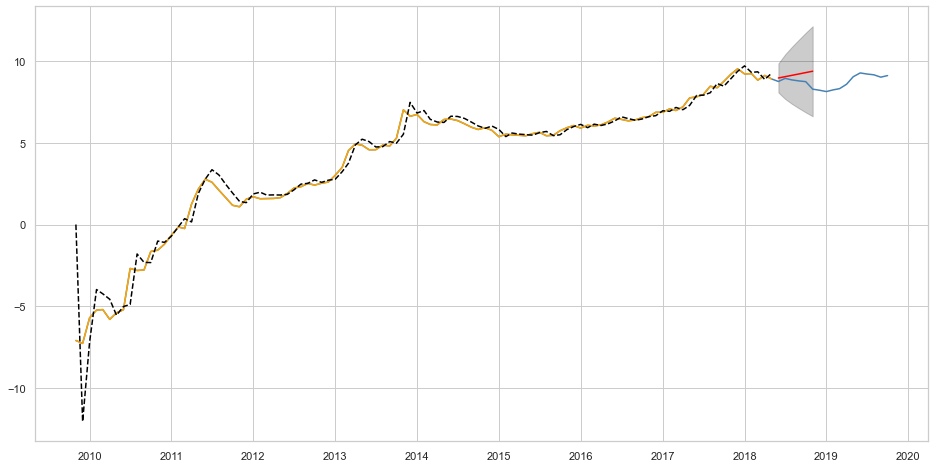

In [59]:
plt.figure(figsize=(16, 8))
plt.plot( monthly_series, color='steelblue' ) # observed test
plt.plot( monthly_train, color='orange' ) # observed train
plt.plot( monthly_cv_tune_fit.fittedvalues, color='black', linestyle='--') # fitted
plt.plot( monthly_cv_tune_forecast, color='red' ) # forecasted
plt.fill_between( 
    monthly_cv_tune_forecast_summary.index, 
    monthly_cv_tune_forecast_summary.forecast_lwr, 
    monthly_cv_tune_forecast_summary.forecast_upr, 
    color = 'black',
    alpha=0.2)

plt.show()

In [60]:
# fucniton to back transform for visualization
def undo_log_transform(z, a):
    return( np.exp(z) - a )

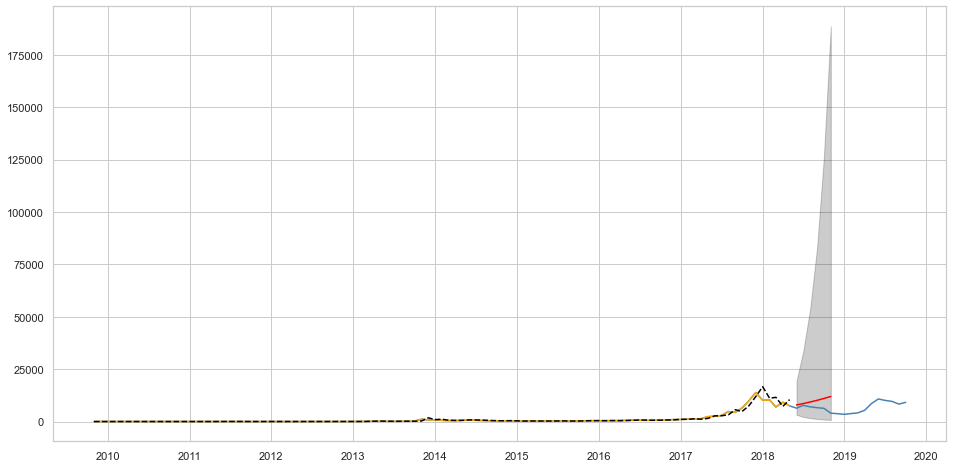

In [61]:
#forecasting median (NOT mean) beahvior
plt.figure(figsize=(16, 8))
plt.plot( monthly_series.index, 
         undo_log_transform(monthly_series.values, 0), color='steelblue' ) # observed test
plt.plot( monthly_train.index,
         undo_log_transform(monthly_train.values, 0), color='orange' ) # observed train
plt.plot( monthly_train.index,
         undo_log_transform(monthly_cv_tune_fit.fittedvalues, 0), color='black', linestyle='--') # fitted
plt.plot( monthly_tune_forecast.index,
         undo_log_transform(monthly_cv_tune_forecast.values, 0), color='red' ) # forecasted
plt.fill_between( 
    monthly_cv_tune_forecast_summary.index, 
    undo_log_transform(monthly_cv_tune_forecast_summary.forecast_lwr, 0), 
    undo_log_transform(monthly_cv_tune_forecast_summary.forecast_upr, 0),
color = 'black',
alpha=0.2)
plt.show()

## RMSEs

In [62]:
monthly_val = monthly_series.loc['2018-06-01':'2018-11-01'].copy()

In [63]:
RMSE_arima = (np.mean( (monthly_val.values - monthly_tune_forecast)**2 )**0.5)
RMSE_arima

0.6351405998113546

In [64]:
RMSE_stl = (np.mean( (monthly_val.values - monthly_ses_forecast)**2 )**0.5)
RMSE_stl

0.771323549682186

In [65]:
RMSE_hw = (np.mean( (monthly_val.values - monthly_hw_forecast)**2 )**0.5)
RMSE_hw

0.5562175652313928

In [66]:
RMSE_arima_cv = (np.mean( (monthly_val.values - monthly_cv_tune_forecast)**2 )**0.5)
RMSE_arima_cv

0.5524991625453854

In [67]:
RMSE = {'ARIMA':RMSE_arima,
    'SES with STL':RMSE_stl,
    'Holt-Winters':RMSE_hw,
    'ARIMA with CV':RMSE_arima_cv}

sorted(RMSE.items(), key=lambda x: x[1])

[('ARIMA with CV', 0.5524991625453854),
 ('Holt-Winters', 0.5562175652313928),
 ('ARIMA', 0.6351405998113546),
 ('SES with STL', 0.771323549682186)]